# California House Price Prediction

This project is an end-to-end machine learning solution for predicting housing prices in California. The application is built using FastAPI for serving the machine learning model and Docker for containerization, ensuring easy deployment and scalability.

## [Data](#data)
- ### Exploratory Data Analysis
- ### Data Visualization
- ### Missing Value Check
- ### Multicollinearity

## [Modeling](#modeling)
- ### Data Preparation
- ### Cross Validation
- ### Best Model
- ### Model Evaluation
- ### Feature Importance

## [Serialization](#serialization)
- ### Serialization
- ### Deserialization
- ### New Predictions

In [41]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

## Data<a id='data'></a>

In [42]:
data = pd.read_csv('housing.csv')
print(data.shape)
data.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory Data Analysis (EDA)

In [43]:
cols = data.columns
cols

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [44]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


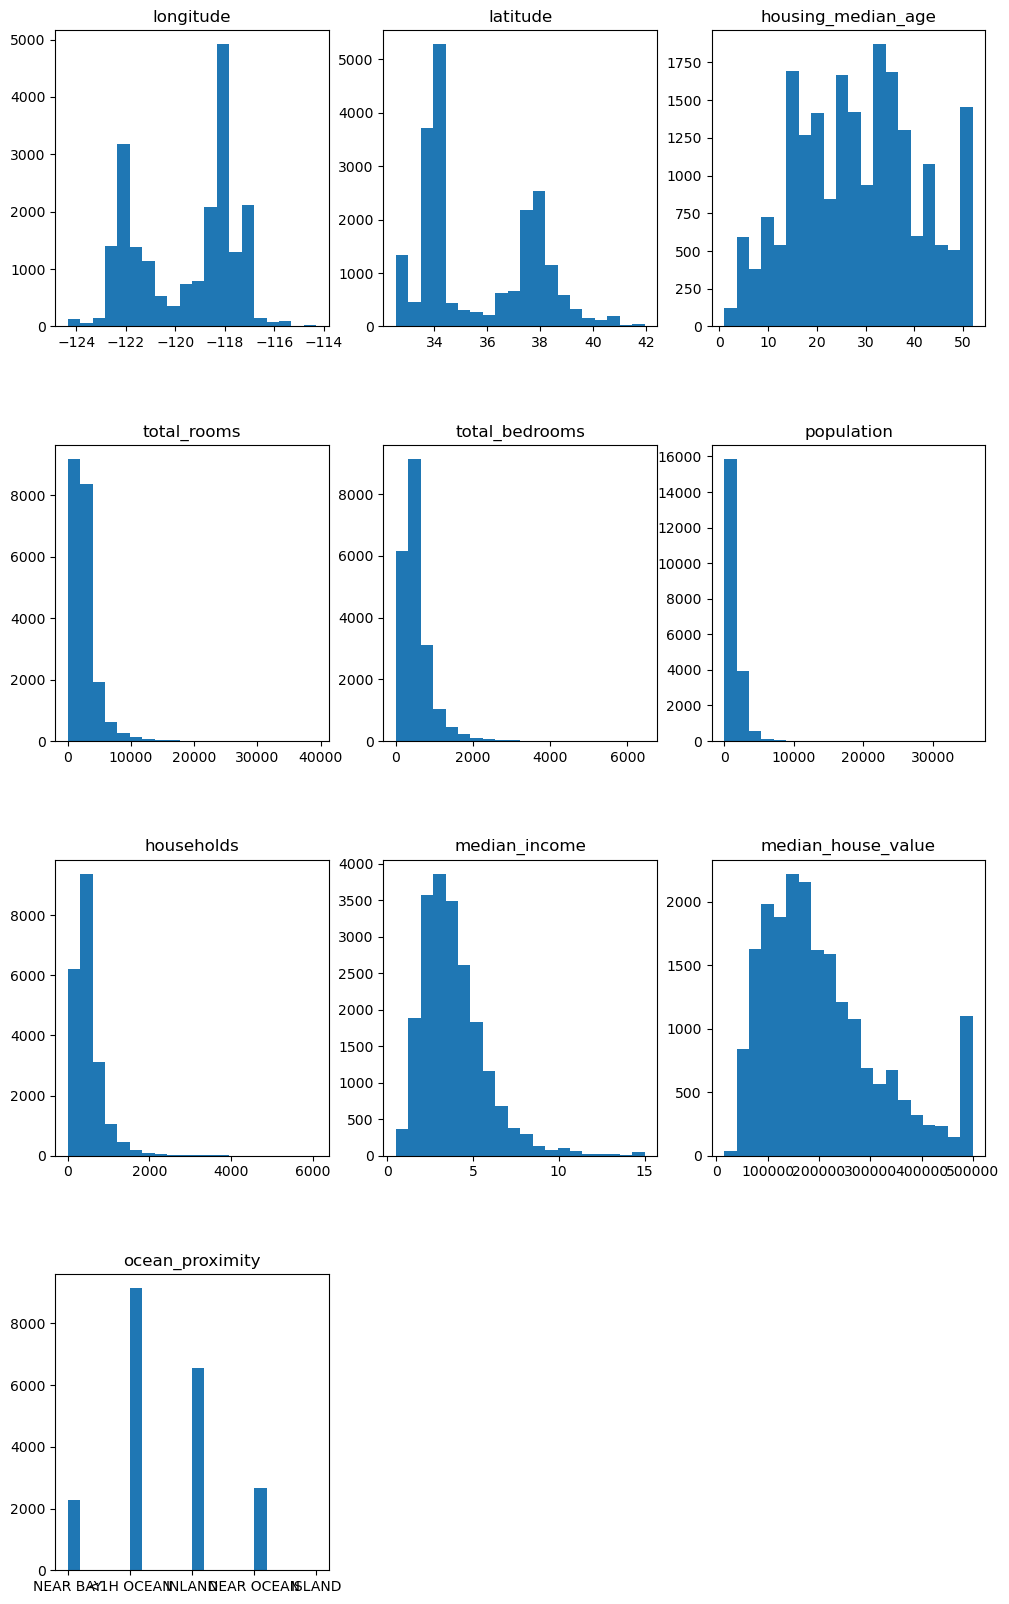

In [46]:
# Create three columns of subplots
vert_plots = 3
cols = data.columns

# Create a number of rows of subplots based on how many columns are in the dataset.
hor_plots = data.shape[1] // vert_plots

# Create the plots in a grid
if data.shape[1] % hor_plots > 0:
    hor_plots = data.shape[1] // vert_plots + 1
    
plt.figure(figsize=(12,20))
plt.subplots_adjust(hspace=0.4)

col_idx = 0

for vert_plot in range(vert_plots):
    for hor_plot in range(hor_plots):
        if col_idx >= len(cols):
            continue
        col = cols[col_idx]

        plt.subplot(hor_plots,vert_plots,col_idx+1)
        plt.hist(data[col], bins=20)
        col_idx += 1
        ax = plt.gca()
        ax.set_title(col)

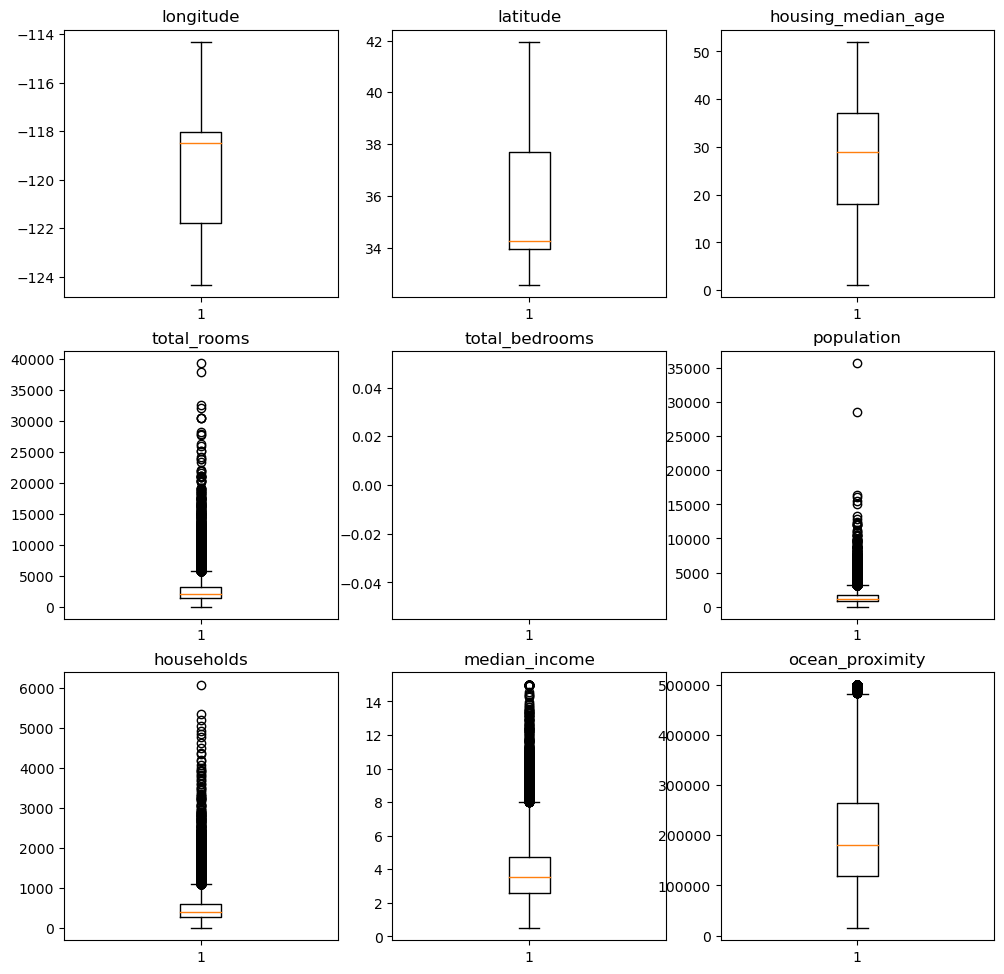

In [47]:
# Box plots, which won't include ocean proximity
vert_plots = 3
hor_plots = data.shape[1] // vert_plots

if data.shape[1] % hor_plots > 0:
    hor_plots = data.shape[1] // vert_plots + 1

plt.figure(figsize=(12,16))
plt.subplots_adjust(hspace=0.2)

col_idx = 0

for vert_plot in range(vert_plots):
    for hor_plot in range(hor_plots):
        if col_idx >= len(cols):
            continue
        col = cols[col_idx]
        
        if col != 'ocean_proximity':
            plt.subplot(hor_plots,vert_plots,col_idx+1)
            try:
                plt.boxplot(data[col])
            except:
                pass
        ax = plt.gca()
        ax.set_title(col)
        col_idx += 1

#### Missing Value

In [48]:
print('Total number of missing values:\n', data.isnull().sum())

Total number of missing values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


### Multicollinearity

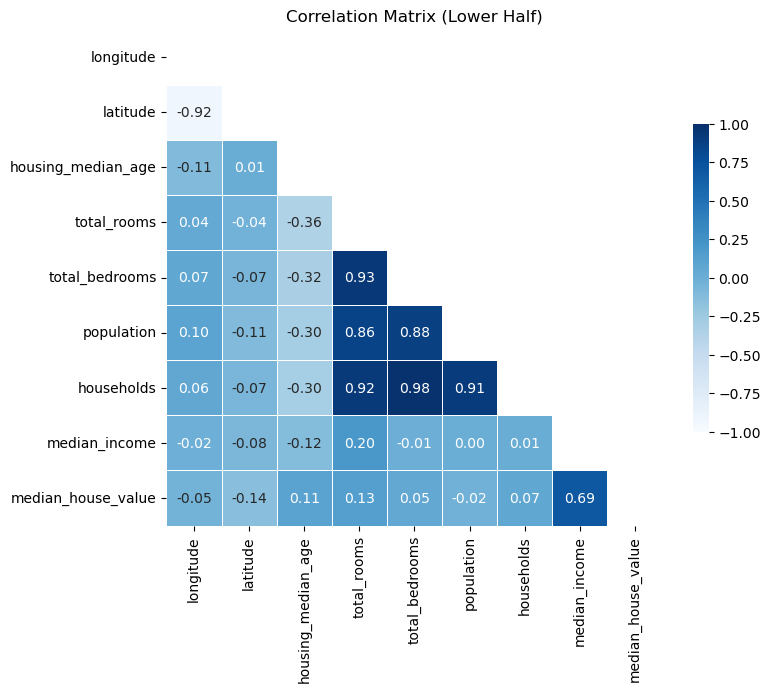

In [49]:
corr_matrix = data.select_dtypes(include='float64').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='Blues', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add a title
plt.title('Correlation Matrix (Lower Half)')

# Show the plot
plt.show()

## Modeling<a id='modeling'></a>
### Data Preparation

In [50]:
sTargetFeature = 'median_house_value'
lst_numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
                        'total_bedrooms', 'population', 'households', 'median_income']
lst_categorical_features = ['ocean_proximity']

In [51]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Standardize the numerical features
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features
])

# Combine the numeric and categorical transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, lst_numeric_features),
        ('cat', categorical_transformer, lst_categorical_features)
    ])

# Create the full pipeline with a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor()) #This is a placeholder, will be replaced during cross validation
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('regressor', GradientBoostingRegressor())])

In [52]:
# Split the data into training and testing sets
X = data.drop([sTargetFeature], axis=1)
y = data[sTargetFeature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Cross Validation

In [53]:
# Define the parameter grid
param_grid = [
    {
        'regressor': [LinearRegression()],
    },
    {
        'regressor': [Ridge()],
        #'regressor__alpha': [0.1, 1.0, 10.0]  # Ridge-specific hyperparameter
    },
    {
        'regressor': [RandomForestRegressor()],
        #'regressor__n_estimators': [50, 100],
        #'regressor__max_depth': [None, 10, 20]  # RandomForest-specific hyperparameters
    },
    {
        'regressor': [GradientBoostingRegressor()],
        #'regressor__n_estimators': [50, 100],
        #'regressor__max_depth': [None, 10, 20]  # RandomForest-specific hyperparameters
    }    
]

# Use GridSearchCV to find the best algorithm and hyperparameters
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')


# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best model and hyperparameters
print("Best model:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)

Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(step

### Best Model

In [54]:
# Create the full pipeline with a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor()) #This is a placeholder, will be replaced during cross validation
])

print(model_pipeline)

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model_pipeline.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer

### Model Evaluation

In [55]:
r2s  = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2 Score: {r2s:,.2f}')
print(f'Root Mean Squared Error: {rmse:,.2f}')
print(f'Mean Absolute Error: {mae:,.2f}')
print(f'Mean Absolute Percentage Error: {mape:,.2f}')

# Feature Importance
# get_feature_importance(model_pipeline, 'regressor')

R2 Score: 0.82
Root Mean Squared Error: 49,155.78
Mean Absolute Error: 31,652.48
Mean Absolute Percentage Error: 0.18


### Feature Importance

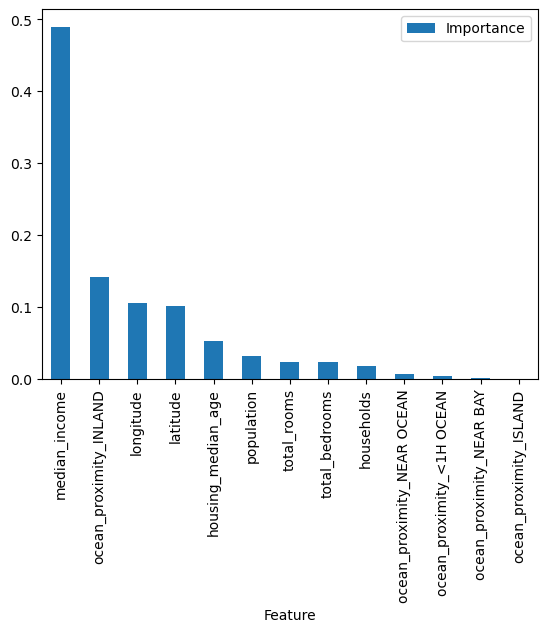

In [56]:
# Get the model from the pipeline
trained_model = model_pipeline.named_steps['regressor']

# Get the feature importances
importances = trained_model.feature_importances_

# Get feature names from the preprocessing step
feature_names = lst_numeric_features + list(model_pipeline.named_steps['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(lst_categorical_features))

# Combine into a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

df_fi = feature_importance_df.head(20)
# print(df_fi)
df_fi.plot(kind='bar', x='Feature', y='Importance');

## Serialization<a id='serialization'></a>

### Serialization

In [57]:
import pickle

In [58]:
filename = 'regressor.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model_pipeline, file)
    
print(f"Model saved to {filename}")

Model saved to regressor.pkl


### Deserialization

In [59]:
filename = 'regressor.pkl'

with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

print(f"Model loaded from {filename}")

Model loaded from regressor.pkl


### New Predictions

In [60]:
# Build Input JSON string
json_string = '''
[
 {
  "longitude":-119.01,
  "latitude":36.06,
  "housing_median_age":25.0,
  "total_rooms":1505.0,
  "total_bedrooms":null,
  "population":1392.0,
  "households":359.0,
  "median_income":1.6812,
  "ocean_proximity":"INLAND"
 },
 {
  "longitude":-119.46,
  "latitude":35.14,
  "housing_median_age":30.0,
  "total_rooms":2943.0,
  "total_bedrooms":null,
  "population":1565.0,
  "households":584.0,
  "median_income":2.5313,
  "ocean_proximity":"INLAND"
 },
 {
  "longitude":-122.44,
  "latitude":37.8,
  "housing_median_age":52.0,
  "total_rooms":3830.0,
  "total_bedrooms":null,
  "population":1310.0,
  "households":963.0,
  "median_income":3.4801,
  "ocean_proximity":"NEAR BAY"
 },
 {
  "longitude":-118.72,
  "latitude":34.28,
  "housing_median_age":17.0,
  "total_rooms":3051.0,
  "total_bedrooms":null,
  "population":1705.0,
  "households":495.0,
  "median_income":5.7376,
  "ocean_proximity":"<1H OCEAN"
 },
 {
  "longitude":-121.93,
  "latitude":36.62,
  "housing_median_age":34.0,
  "total_rooms":2351.0,
  "total_bedrooms":null,
  "population":1063.0,
  "households":428.0,
  "median_income":3.725,
  "ocean_proximity":"NEAR OCEAN"
 }
]
'''

In [61]:
# Convert JSON string to input DataFrame
df_input = pd.read_json(json_string)
df_input

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-119.01,36.06,25,1505,NaN,1392,359,1.6812,INLAND
1,-119.46,35.14,30,2943,NaN,1565,584,2.5313,INLAND
2,-122.44,37.80,52,3830,NaN,1310,963,3.4801,NEAR BAY
3,-118.72,34.28,17,3051,NaN,1705,495,5.7376,<1H OCEAN
4,-121.93,36.62,34,2351,NaN,1063,428,3.7250,NEAR OCEAN


In [62]:
# Predicted Price
new_predictions = model_pipeline.predict(df_input).round()
print(new_predictions)

[ 51274.  70021. 458144. 243146. 273148.]
